In [1]:
import dataloader
import madmom
import numpy as np

id = 21 # 21:let it be -> easy and clear harmony
split = 3
dataset = dataloader.MIRDataset("beatles",use_deep_chroma=True,align_chroma=True,split_nr=split)
tracks = dataset.getTrackList()
track_id = list(tracks.keys())
id = 21 # 21:let it be -> easy and clear harmony
## load track
y,t_chroma,chroma,ref_intervals,ref_labels = dataset[track_id[id]]

activations_processor = madmom.features.beats.RNNBeatProcessor()
beat_processor = madmom.features.beats.BeatTrackingProcessor(fps=100)

LOADING AUDIO: 
06_-_Let_It_Be ID: 1206


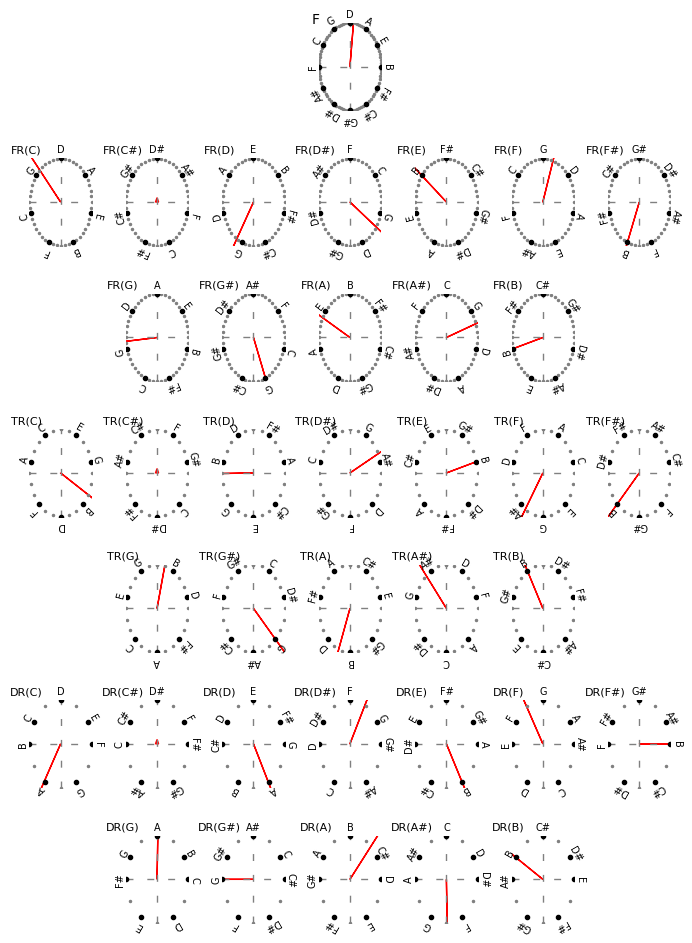

In [3]:
import circularPitchSpace as cps

rho_F,rho_FR,rho_TR,rho_DR = cps.transformChroma(chroma)

# plot pitchspace
fig,axes = cps.plotPitchSpace()
cps.plotFeatures(axes,rho_F[20],rho_FR[20,:],rho_TR[20,:],rho_DR[20,:],'r')

In [55]:
import matplotlib.colors as mcolors
def plotAnnotations(ax,intervals,labels,height=0.5,time=(0,10)):
    colors = list(mcolors.TABLEAU_COLORS.keys())  # type: list
    for i,label in enumerate(labels):
        if intervals[i,0] >= time[0] and intervals[i,0] <= time[1]:
            print(intervals[i,:])
            rect = patches.Rectangle((intervals[i,0], 0), intervals[i,1], 2*height,facecolor=colors[i],alpha=0.8)
            ax.add_patch(rect)
            ax.text(intervals[i,0]+(intervals[i,1]-intervals[i,0])/2,height,label,fontsize=15,verticalalignment="center")
    ax.set_ylim(0,2*height)
    ax.set_xlim(0,10)
    ax.axis('off')

Transcribing with Chord Templates
[0.       0.175157]
[0.175157 1.852358]
[1.852358 3.454535]
[3.454535 4.720022]
[4.720022 5.126371]
[5.126371 5.95068 ]
[5.95068  6.774988]
[6.774988 8.423605]
[ 8.423605 10.014172]


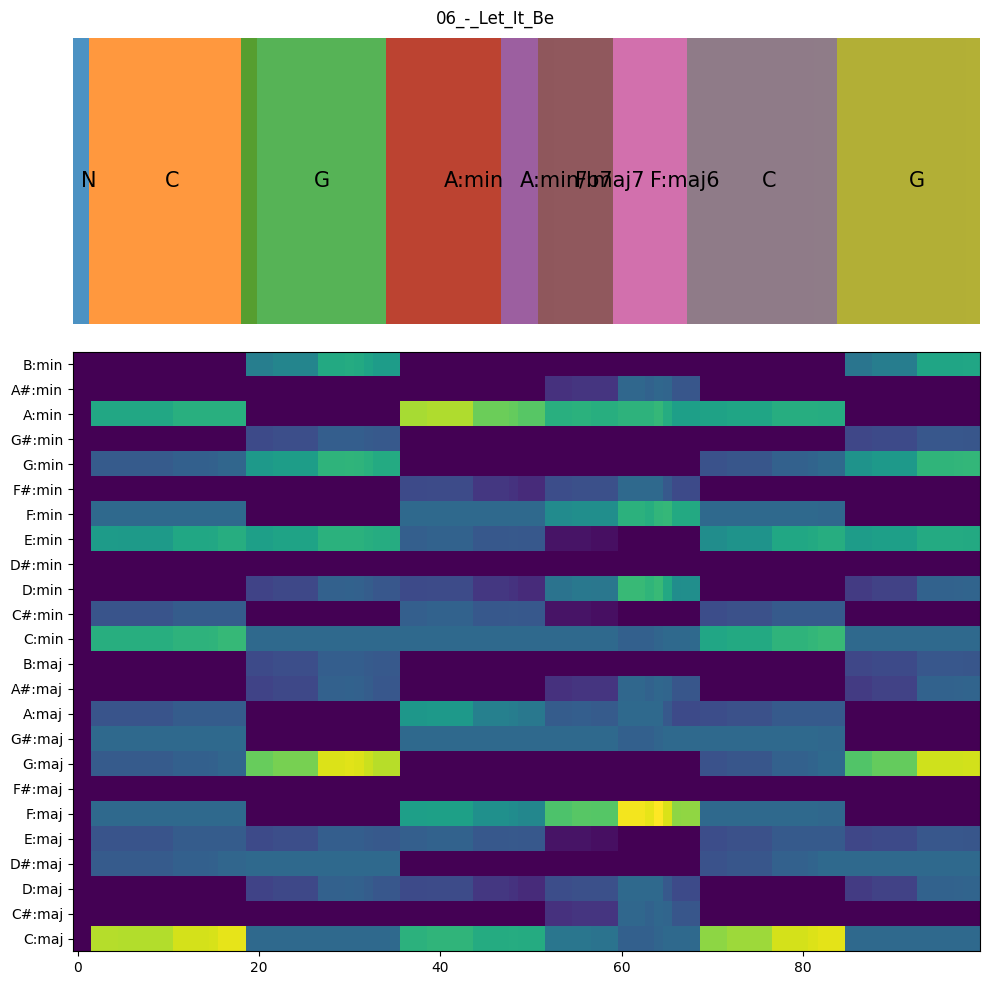

In [56]:
# create correlation matrix
from transcribe import createChordTemplates,transcribeChromagram
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import utils
labels,templates = createChordTemplates()
est_intervals,est_labels = transcribeChromagram(t_chroma,chroma,"TEMPLATE")
max_vals = np.max(chroma, axis=1)
chroma_norm = chroma / (max_vals[:,None]+np.finfo(float).eps)
correlation = np.dot(templates,chroma_norm.T)     # 25xN

# PLOT Correlation matrix vs annotation and prediction #####
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0,0))
ax2 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)
fig.suptitle(f"{tracks[track_id[id]]}")
plotAnnotations(ax1,ref_intervals,ref_labels)
# utils.plotAudioWaveform(ax1,y)
# utils.plotAnnotations(ax1,ref_intervals,ref_labels)
# utils.plotPredictionResult(ax1,est_intervals,est_labels)

ax2.imshow(correlation[:,:100],origin="lower", aspect='auto')
ax2.set_yticks(range(len(labels)))
ax2.set_yticklabels(labels);

fig.tight_layout(h_pad=2)
#############################################################

In [32]:

max_correlation = np.argmax(correlation,axis=0)
max_correlation_counts = np.bincount(max_correlation)
max_correlation_counts_index = np.argsort(max_correlation_counts)[::-1]
print("Chords sorted by appearance")
print([labels[i] for i in max_correlation_counts_index])
Cxx = np.cov(correlation) # covariance matrix
evalues, evec = LA.eig(Cxx)
# get index of sorted eigenvalues in reverse order
evalues_idx = np.argsort(evalues)[::-1]
# create a boolean mask for the biggest eigenvalues
mask = np.array((np.cumsum(evalues[evalues_idx])/np.sum(evalues)) < 0.97)

largest_evalues = evalues[evalues_idx][mask]
largest_evalues_idx = evalues_idx[mask]
largest_evec = evec[:,largest_evalues_idx]

# project Correlation matrix using the first 3 eigenvectors
Erg = np.matmul(largest_evec[:,:3].T,correlation)

harm_mean = np.zeros((3,3))
# compute harmonic vectors for the 3 most common chords
for i,template_index in enumerate(max_correlation_counts_index[:3]):
    x = np.argwhere(max_correlation == template_index)
    harm_mean[:,i] = np.mean(Erg[:,x],axis=1).T

print(harm_mean)
# noch zu erledigen
# ---> Distanz zwischen dem harmonischen Mittelvektor und dem Korrelat zu jeden Zeitpunkt


# find most 
# %% *** Abbildung der Harmonien im 3D-Raum ***
# % Räumliche Nähe: [C,a],  [F,d] und [G,e ]  
# % [C F G] spannen ein 3-Eck auf ...

# SelChroma ... Template mit höchster Korrelation für jeden Zeitpunkt
# Erg = V(:,pos(1:3))'*(M'*CHROMAmean);
# figure(fig),fig = fig+1;
#     scatter3(Erg(1,:)',Erg(2,:)',Erg(3,:)',80,SelChroma)
# hold on

# für die am häufigsten auftretenden Templates wird ein mittlerer Eigenvektor berechnet
# countpos -> Index der häufigsten Templates (SelChroma)
# for ii = 1:maxEig
#     ind = find(SelChroma==countpos(ii));
#     scatter3(Erg(1,ind)',Erg(2,ind)',Erg(3,ind)',50,SelChroma(ind),'filled')
#     harmMean(:,ii) = mean(Erg(:,ind),2);

# harmMean .. mittlere Eigenvektoren, welche den am häufigsten auftretenden Harmonien zugeordnet werden können.

# end
# legend({'All',harmLabels{countpos(1:maxEig)}})
# for ii = 1:maxEig
#     %scatter3(harmMean(1,ii),harmMean(2,ii),harmMean(3,ii),500,'k','x')
#     scatter3(harmMean(1,ii),harmMean(2,ii),harmMean(3,ii),500,countpos(ii),'x')
# end

Chords sorted by appearance
['C:maj', 'F:maj', 'G:maj', 'A:min', 'E:min', 'A:maj', 'F:min', 'F#:min', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'G:min', 'F#:maj', 'G#:maj', 'G#:min', 'B:maj', 'C:min', 'C#:min', 'D:min', 'D#:min', 'A#:maj']
[[ 0.05538009  2.79882597 -2.72659849]
 [-3.00445414 -0.16543454 -0.08034904]
 [ 1.77072426  1.93371332  2.36891297]]


/tmp/ipykernel_311639/187586204.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  harm_mean[:,i] = np.mean(Erg[:,x],axis=1).T


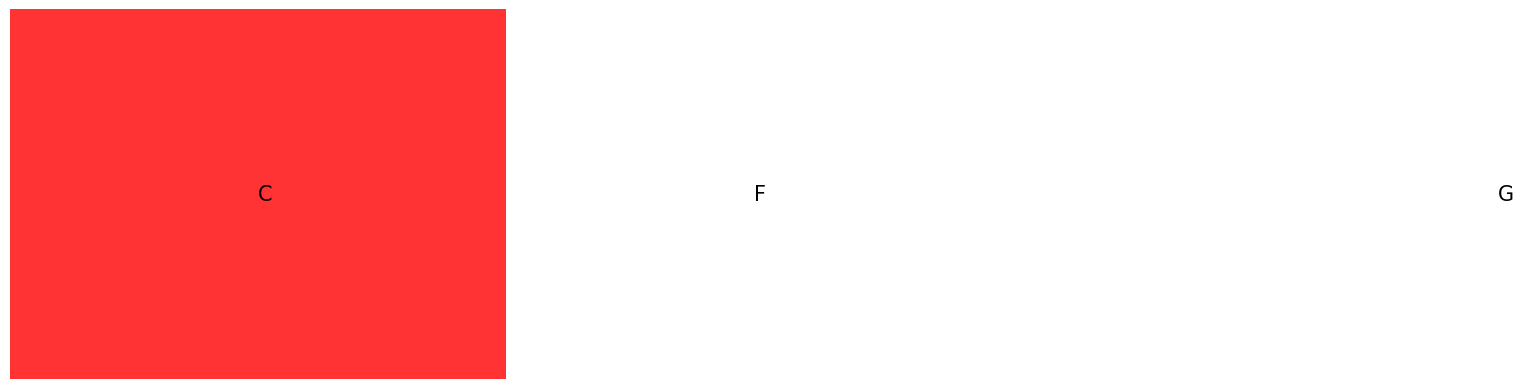

In [33]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
# how to iterate over a colormap
def plotAnnotations(ax,intervals,labels,height=0.5):
    for i,label in enumerate(labels):
        rect = patches.Rectangle((intervals[i,0], 0), intervals[i,1], 2*height,facecolor='r',alpha=0.8)
        ax.add_patch(rect)
        ax.text((intervals[i,1]-intervals[i,0])/2,height,label,fontsize=15,verticalalignment="center")
    ax.set_ylim(0,2*height)
    ax.axis('off')
    
color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
             'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1], 'N': [1, 1, 1, 1]}
# Plot
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [4, 0.3, 0.3, 0.3]}, 
                       figsize=(9, 6))


fig,ax = plt.subplots()
labels = ["C","F","G"]
intervals = np.array([[0,1],[1,4],[4,10]])
plotAnnotations(ax,intervals,labels)